In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

In [5]:
import os
os.chdir('drive/MyDrive/modules')
!nvidia-smi

Sat Feb 12 15:59:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# from here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import keras
from keras.layers import Dense, Input, GlobalAveragePooling1D, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Activation, AveragePooling2D, Flatten
# from tensorflow.keras.applications.vgg16 import VGG16
import argparse
from imutils import paths
from sklearn.metrics import recall_score, precision_score, f1_score, \
    accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay

from aspectawarepreprocessor import AspectAwarePreprocessor
from imagetoarraypreprocessor import ImageToArrayPreprocessor
from simpledatasetloader import SimpleDatasetLoader

from tensorflow.keras.optimizers import Adam,SGD
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
from keras import backend as K, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers as L
import tensorflow as tf
# from keract import get_activations, display_activations
from matplotlib import pyplot

# Process Images

In [7]:
parent = "/content/drive/MyDrive/Data/train_images/train_images"

labels_train = pd.read_csv("/content/drive/MyDrive/Data/labels_train.csv")

imagePaths = []
for path in labels_train['file_name']:
  wholePath = os.path.join(parent,path)
  imagePaths.append(wholePath)
sp = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
X = sdl.load(imagePaths, verbose=500)

Y_train = [l for l in labels_train['class_id']]

X_train, X_val, Y_train, Y_val = train_test_split(X,Y_train,test_size=0.33,shuffle=True)

X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

Y_train = tf.keras.utils.to_categorical(Y_train,num_classes=3)
Y_val = tf.keras.utils.to_categorical(Y_val,num_classes=3)

print(f"[INFO] Found {X_train.shape[0]} images for training with shape:{X_train.shape[1:]}.")
print(f"[INFO] Found {X_val.shape[0]} images for validation with shape:{X_val.shape[1:]}.")

[INFO] processed 500/4672
[INFO] processed 1000/4672
[INFO] processed 1500/4672
[INFO] processed 2000/4672
[INFO] processed 2500/4672
[INFO] processed 3000/4672
[INFO] processed 3500/4672
[INFO] processed 4000/4672
[INFO] processed 4500/4672
[INFO] Found 3130 images for training with shape:(224, 224, 3).
[INFO] Found 1542 images for validation with shape:(224, 224, 3).


# Augment Data

In [8]:
datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.05
)
datagen.fit(X_train)

# Custom CNN

In [9]:
model_version = "_v6.h5"
model_path = "/content/drive/MyDrive/Saved_Models/custom_cnn"

model_name = os.path.join(model_path,model_version)

print("Custom CNN selected")

def conv(model,filters):
  model = L.SeparableConv2D(filters=filters,kernel_size=3, activation='relu',padding='same')(model)
  model = L.BatchNormalization()(model)
  model = L.MaxPool2D()(model)
  return model


def dense(model,units,rate):
  model = L.Dense(units=units, activation='relu')(model)
  model = L.BatchNormalization()(model)
  model = L.Dropout(rate)(model)
  return model

if os.path.isfile(model_name):
  print("Loading Model..")
  model = tf.keras.models.load_model(model_name)
else:
  print("Creating Model..")
  x_in = L.Input((224,224,3))
  x = L.Conv2D(filters=16, kernel_size=3, padding='same')(x_in)
  x = L.Conv2D(filters=16, kernel_size=3, padding='same')(x)
  x = L.MaxPool2D()(x)
  x = conv(x,32)
  x - L.Dropout(0.25)(x)
  x = conv(x,64)
  x = conv(x,128)
  x = conv(x,256)
  x - L.Dropout(0.7)(x)
  x = L.Flatten()(x)
  x = dense(x,512,0.7)
  x = dense(x,128,0.5)
  x = dense(x,64,0.3)
  out = L.Dense(3,activation='softmax')(x)
  model = Model(inputs=x_in, outputs=out)
  model.compile(
        optimizer=Adam(learning_rate=0.0001, decay=1e-6),
        loss="categorical_crossentropy",
        metrics=['acc']
    )
  model.save(model_name)
model.summary()

Custom CNN selected
Creating Model..
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 112, 112, 32)     688       
 Conv2D)                                                         
                                                                 
 batch_normalization (Ba

# Callbacks

In [10]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=0.0000001, verbose=1)


model_weights = 'custom_cnn_v6-e{epoch:04d}-loss{loss:.3f}-acc{acc:.3f}-valloss{val_loss:.3f}-valacc{val_acc:.3f}.h5'
checkpoint_filepath = os.path.join("/content/drive/MyDrive/Weights",model_weights)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1)

calls = [lr_reducer,modelCheckpoint]

# Train

In [11]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),epochs=100, verbose=1, validation_data=(X_val,Y_val),callbacks=calls)
print("Saving Trained Model..")
model.save(model_name)

Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 1.1738 - acc: 0.5431
Epoch 00001: val_loss improved from inf to 1.04394, saving model to /content/drive/MyDrive/Weights/custom_cnn_v6-e0001-loss1.174-acc0.543-valloss1.044-valacc0.501.h5
98/98 [==============================] - 46s 352ms/step - loss: 1.1738 - acc: 0.5431 - val_loss: 1.0439 - val_acc: 0.5013 - lr: 1.0000e-04
Epoch 2/100
98/98 [==============================] - ETA: 0s - loss: 1.0175 - acc: 0.5968
Epoch 00002: val_loss did not improve from 1.04394
98/98 [==============================] - 33s 332ms/step - loss: 1.0175 - acc: 0.5968 - val_loss: 1.1005 - val_acc: 0.5013 - lr: 1.0000e-04
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 0.9467 - acc: 0.6220
Epoch 00003: val_loss did not improve from 1.04394
98/98 [==============================] - 32s 329ms/step - loss: 0.9467 - acc: 0.6220 - val_loss: 1.5733 - val_acc: 0.2613 - lr: 1.0000e-04
Epoch 4/100
98/98 [==========================

# Evaluate on Validation Images

In [12]:
scores = model.evaluate(X_val,Y_val)
print(f"Validation Loss :{scores[0]}")
print(f"Validation Accuracy :{scores[1]}")

49/49 [==============================] - 1s 23ms/step - loss: 0.6095 - acc: 0.7633
Validation Loss :0.609451174736023
Validation Accuracy :0.7632943987846375


# Plot models

Ploting Training Metrics..


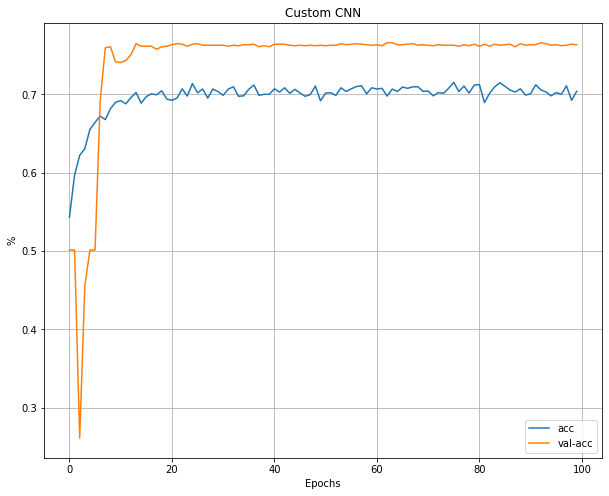

In [13]:
print("Ploting Training Metrics..")
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Custom CNN")
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)